<h1>Ball and stick 1: Basic cell</h1>

This is the first part of a several page tutorial that will ultimately build a ring network of mutlicompartment neurons running on a parallel machine.

Best software engineering practice is to carefully design both the model and code. A well-designed system is easier to debug, maintain, and extend.

This tutorial will take a functional bottom-up approach, building key components and refactoring as needed for a better software design instead of describing a complex design and filling in the pieces.

This part of the tutorial builds a two-compartment neuron consisting of a soma and dendrite. This representation is known as a <i>ball-and-stick</i> model. After building the cell, we will attach some instrumentation to it to simulate and monitor its dynamics.

<h2>Load NEURON</h2>

We of course begin by loading NEURON's main submodule <tt>h</tt>.

In [1]:
from neuron import h

As good practice, we'll load some unit definitions:

In [2]:
from neuron.units import ms, mV

We'll load the standard run library to give us high-level simulation control functions (e.g. running a simulation for a given period of time):

In [3]:
h.load_file('stdrun.hoc')

1.0

If we're running in Jupyter, we should allow interactive graphics inline so that we can explore our <tt>PlotShape</tt>s interactively; skip this line if you're not using Jupyter (it'll cause a syntax error):

In [4]:
%matplotlib notebook

<h2>Defining the cell morphology</h2>

<h3>Create the sections</h3>

A ball-and-stick cell by definition consists of two parts: the soma (ball) and a dendrite (stick). We could define two Sections at the top level as in the previous tutorial, but that wouldn't give us an easy way to create multiple cells. Instead, let's define a <tt>BallAndStick</tt> neuron class. The basic boilerplate for defining any class in Python looks like:

In [5]:
class BallAndStick:
    def __init__(self):
         """anything that should be done every time one of these is created goes here"""

In our case in particular, every time we say that there is a <tt>BallAndStick</tt> cell, we should create the soma and the dendrite sections:

In [6]:
class BallAndStick:
    def __init__(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)

Any variables that describe properties of the cell must get stored as attributes of <tt>self</tt>. This is why we write <tt>self.soma</tt> instead of <tt>soma</tt>. Temporary variables, on the other hand, need not be prefixed with self and will simply stop existing when the initialization function ends.

You will also note that we have introduced a new keyword argument for <tt>Section</tt>, namely the cell attribute. This will always be set to <tt>self</tt> (i.e. the current cell) to allow each Section to know what cell it belongs to.

Recall that we can check the topology via:

In [7]:
h.topology()

1.0

No sections were displayed. Why?

The explanation is that we haven't actually created any such cells yet; we've only defined a rule for them. Let's go ahead and create our first cell:

In [8]:
my_cell = BallAndStick()

We again check the topology and see that the sections have in fact been created:

In [9]:
h.topology()


|-|       <__main__.BallAndStick object at 0x11e9ff7f0>.soma(0-1)
|-|       <__main__.BallAndStick object at 0x11e9ff7f0>.dend(0-1)



1.0

Clearly there is a soma and a dendrite, but the cell identifier before each is not very friendly.

We can specify how the cell displays using the `__repr__` method:

In [10]:
class BallAndStick:
    def __init__(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
    def __repr__(self):
        return 'BallAndStick'

In [11]:
h.topology()


|-|       <__main__.BallAndStick object at 0x11e9ff7f0>.soma(0-1)
|-|       <__main__.BallAndStick object at 0x11e9ff7f0>.dend(0-1)



1.0

Our sections display based on the rule they were created with, not the new rule, so we need to recreate the cell:

In [12]:
my_cell = BallAndStick()

Now we see something friendlier:

In [13]:
h.topology()


|-|       BallAndStick.soma(0-1)
|-|       BallAndStick.dend(0-1)



1.0

There's a problem though; do you see it?

Every cell using this rule would print out the same cell identifier. So if we create a second cell:

In [14]:
my_other_cell = BallAndStick()

and look at the topology:

In [15]:
h.topology()


|-|       BallAndStick.soma(0-1)
|-|       BallAndStick.dend(0-1)
|-|       BallAndStick.soma(0-1)
|-|       BallAndStick.dend(0-1)



1.0

There is no way to tell the two somas apart and see which goes with which cell. To fix this, we'll pass in an identifier <tt>gid</tt> when we create the cell and have `__repr__` incorporate that into the name:

In [16]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

Important: the cell name (returned by `__repr__`) will be read when the Section is created, so any and all data that function needs -- here the `gid` -- must be stored before creating any Section objects.

Now let's create our two cells:

In [17]:
my_cell = BallAndStick(0)
my_other_cell = BallAndStick(1)

Now when we look at the topology, we can tell the Sections belonging to the two cells apart:

In [18]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
|-|       BallAndStick[0].dend(0-1)
|-|       BallAndStick[1].soma(0-1)
|-|       BallAndStick[1].dend(0-1)



1.0

We can tell which sections are the soma and which are dendrites. We can see which go with cell 0 and which go with cell 1, but there is nothing indicating that the dendrite is connected to the soma. This is because we have not told NEURON about any such relationships, so let's do so:

<h3>Connect the sections</h3>

We attach `self.dend` to the `self.soma` using the `connect` method:

In [19]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

As before, we must recreate the cells now that we've changed the rule:

In [20]:
my_cell = BallAndStick(0)
my_other_cell = BallAndStick(1)

Note that this is not equivalent to attaching the `soma` to the `dend`; instead it means that the dendrite begins where the soma ends. We can see that in the topology:

In [21]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend(0-1)
|-|       BallAndStick[1].soma(0-1)
   `|       BallAndStick[1].dend(0-1)



1.0

For now, we can get rid of `my_other_cell`:

In [22]:
del my_other_cell

In [23]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend(0-1)



1.0

A `soma` can have many dendrites attached to it, but any dendrite only begins at one specific location.

What if we didn't want to attach the dendrite to the end of the soma (position 1)? We could explicitly specify the connection location via, e.g. `self.dend.connect(self.soma(0.5))` which would mean the dendrite was attached to the center of the soma. (Recall: segments are described using normalized positions.)

The 1 end of the soma is said to be the parent of the `dend` section.

<h3>Define stylized geometry</h3>

Let's set the length and the width for both sections. We'll make the soma have length and diameter of 12.6157 microns, the dendrite have length 200 microns and diameter 1 micron.

In [24]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

If you're wondering why that number was chosen for the soma length and diameter: it is because it makes the surface area (which doesn't include end faces) approximately 500 μm<sup>2</sup>:

In [25]:
my_cell.soma(0.5).area()

500.00296377255506

(NEURON only returns areas of segments which is why we asked for the center `soma` segment; since there is only one segment, the area here is the same as the whole Section area.)

Note that the surface area of a cylinder with equal length and diameter
$$
\pi d \ell = \pi d^2 = 4 \pi \left (\frac{d}{2} \right) ^2 = 4 \pi r^2
$$
is the same as the surface area of a sphere with the same diameter.

That is, if we're only interested in electrophysiology modeling, we can substitute a cylindrical soma with equal length and diameter for a spherical soma with the same diameter, as we've done here. (The volume, however, is of course different. So this substitution does not work if we're modeling diffusion or accumulation of ions.)

For the rest of this tutorial page, we'll focus solely on one cell.

In [26]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend(0-1)



1.0

Now it is time to see what the cell looks like:

<IPython.core.display.Javascript object>


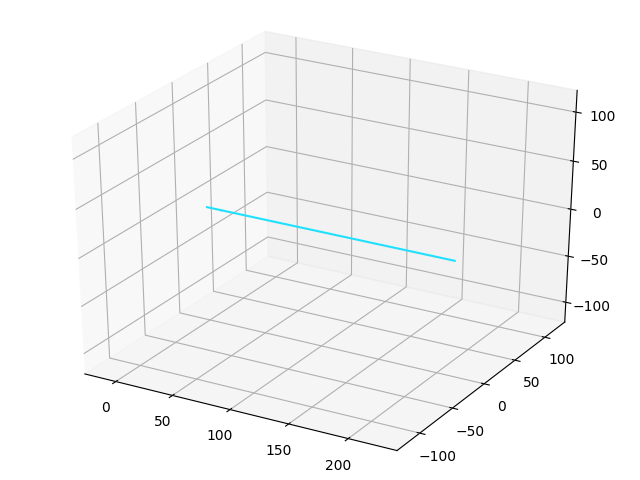

<neuron._PlotShapePlot.__call__.<locals>._get_pyplot_axis3d.<locals>.Axis3DWithNEURON at 0x11f198908>

In [27]:
import matplotlib.pyplot as plt

h.PlotShape(False).plot(plt)

We can also make an interactive shape plot in a separate window using NEURON's built-in graphics, via:

In [28]:
# enable NEURON's graphics
from neuron import gui

# here: True means show using NEURON's GUI; False means do not do so, at least not at first
ps = h.PlotShape(True)

Either way, you will notice that this looks like a line instead of a ball and stick. Why? It's because NEURON by default does not display diameters. This behavior is useful when we need to see the structure of small dendrites, and in NEURON 7.7, it's the only supported option for Jupyter notebooks with h.PlotShape (although gui2.PlotShape provides similar functionality)... but when using NEURON's built-in graphics, we can use the <tt>show</tt> method to show diamters via:

Why does this look like a line instead of a ball and stick? It's because NEURON by default does not display diameters. This behavior is useful when we need to see the structure of small dendrites, but for now, let's show the diameters:

In [29]:
ps = h.PlotShape(True)
ps.show(0)

1.0

In Jupyter, we can rotate images by clicking and dragging; we can zoom by right-clicking and dragging. When using NEURON's built-in graphics which appear in separate windows, right-click and select "3D Rotate", then drag to rotate. For this simple morphology, there is not anything else more to see.

(Note: If you want to build your own visualization tool using matplotlib, mayavi, etc, ensure 3D points exist with `h.define_shape()`, then loop over all the sections with `h.allsec()` and read the morphology using `sec.x3d(i)` etc and `sec.diam3d(i)` for `i` in 0, .., `sec.n3d() - 1`. Less efficiently, the (x, y, z; diam) values for a whole section may be read by `sec.psection()['morphology']['pt3d']`.)

<h3>Specify biophysics</h3>

Our cell needs biophysical mechanisms in the membrane. We start by setting axial resistance and membrane capacitance. (Recall: NEURON's default axial resistance is appropriate for squid but low for mammalian models.)

In [30]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.all = [self.soma, self.dend]                                     # <-- NEW
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
        for sec in self.all:                                                  # <-- NEW
            sec.Ra = 100    # Axial resistance in Ohm * cm                    # <-- NEW
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2     # <-- NEW
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)


We've added a new variable `self.all` which is a list of all the sections in the cell. This will help us iterate over them to -- in this case -- specify axial resistance and membrane capacitance, but can also be used for any other biophysics.

This is getting a little complicated. Let's split `__init__` into several functions:

In [31]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.all = [self.soma, self.dend]
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)


It may not seem like we gained a lot by doing this, but it makes the code a little more self-documenting (e.g. we can see at a glance which parts have to do with defining the morphology) and it divides it into pieces that could be reused in other cells.

We'll put Hodgkin-Huxley (`hh`) kinetics in the soma and specify some parameters:

In [32]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.all = [self.soma, self.dend]
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                                    # <-- NEW           
        for seg in self.soma:                                                     # <-- NEW
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2                   # <-- NEW
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2                # <-- NEW
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2                     # <-- NEW
            seg.hh.el = -54.3     # Reversal potential in mV                      # <-- NEW
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)



(Note: here we loop over all segments in the soma, even though we only defined one segment. This gives us more general code, that will still work if we change the number of segments later. Always write your model implementations to be independent of the discretization.)

Finally, let's insert a passive (leak) current in the dendrite:

In [33]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.all = [self.soma, self.dend]
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite                       # <-- NEW
        self.dend.insert('pas')                                        # <-- NEW
        for seg in self.dend:                                          # <-- NEW
            seg.pas.g = 0.001  # Passive conductance in S/cm2          # <-- NEW
            seg.pas.e = -65    # Leak reversal potential mV            # <-- NEW 
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)


If we weren't sure about the units for a given mechanism’s parameter, use <a class="reference external" href="https://neuron.yale.edu/neuron/static/py_doc/programming/gui/widgets.html#units" title="(in NEURON v7.5)"><code class="xref py py-func docutils literal"><span class="pre">units()</span></code></a>. Pass in a string with the paramater name, an underscore, and then the mechanism name. e.g.

In [34]:
print(h.units('gnabar_hh'))

S/cm2


We can use `psection` to see what is present where:

In [35]:
for sec in h.allsec():
    print('%s: %s' % (sec, ', '.join(sec.psection()['density_mechs'].keys())))

BallAndStick[0].soma: hh
BallAndStick[0].dend: pas


(A quick aside about `psection`: it's great for quickly getting information when interactively exploring a model because it provides a lot of data in one pass; for the same reason, however, other solutions that only extract specific desired information are more efficient for automatic explorations.)

<h2>Instrumentation</h2>

We have now created our neuron. Let's stimulate it and visualize its dynamics.

<h3>Stimulation</h3>

We'll inject a current pulse into the distal (1) end of the dendrite starting 5 ms after the simulation starts, with a duration of 1 ms, and an amplitude of 0.1 nA. First, let's define and position the current clamp object:

In [36]:
stim = h.IClamp(my_cell.dend(1))

If we want, we can check the segment the current clamp is inserted into:

In [37]:
stim.get_segment()

BallAndStick[0].dend(1)

Recall that if we forget what the names of the attributes are, we can check the `dir`. Here we do that and ignore Python-created attributes:

In [38]:
print(', '.join(item for item in dir(stim) if not item.startswith('__')))

amp, baseattr, delay, dur, get_loc, get_segment, has_loc, hname, hocobjptr, i, loc, same


The parameters we need to set for a current clamp are `delay`, `dur`, and `amp`:

In [39]:
stim.delay = 5
stim.dur = 0.2
stim.amp = 1

<h3>Recording</h3>

We'll start out recording the membrane potential at the center of the soma and the time in two NEURON Vectors:

In [40]:
soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

<h2>Run the simulation</h2>

We initialize membrane potential everywhere to -65 mV:

In [41]:
h.finitialize(-65 * mV)

1.0

Now we run until time 25 ms:

In [42]:
h.continuerun(25 * ms)

0.0

<h2>Plot the results</h2>

As in the scripting neuron basics part of the tutorial, we initialize `bokeh` graphics:

In [43]:
from bokeh.io import output_notebook
import bokeh.plotting as plt
output_notebook()

Loading BokehJS ...

(If you prefer to use `matplotlib` graphics, you can adapt the code below using the examples in the scripting neuron basics part of the tutorial.)

Now we plot membrane potential vs time:

In [44]:
f = plt.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, soma_v, line_width=2)
plt.show(f)

<h2>Simulation studies</h2>

Now that we have a single cell that generates an action potential in response to current injection, let's see what else we can do:

<h3>Role of current amplitude</h3>

Let's do a set of simulations, plotted in the same figure, where we vary the amplitude of the current in a `for` loop:

In [45]:
f = plt.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
for amp, color in [(0.075, 'green'), (0.15, 'blue'), (0.225, 'red'), (0.3, 'black')]:
    stim.amp = amp
    h.finitialize(-65 * mV)
    h.continuerun(25 * ms)
    f.line(t, list(soma_v), line_width=2, legend='amp=%g' % amp, color=color)
plt.show(f)

The `for` loop syntax as used here is looping over amplitude, color pairs. The only potential "gotcha" here is the need to pass in `list(soma_v)` instead of `soma_v`. If this copying was omitted, only the last set of values would be plotted.

<h3>Plotting both the dendrite and the soma</h3>

To plot the dendrite potential, we need to record it in a NEURON Vector:

In [46]:
dend_v = h.Vector().record(my_cell.dend(0.5)._ref_v)

Note that we do not need to reassign the existing time and soma membrane potential recording vectors.

The running and plotting code is very similar to the above; the only difference is one additional call to the `line` method to plot the `dend_v` using a dashed line without a separate legend entry:

In [47]:
f = plt.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
for amp, color in [(0.075, 'green'), (0.15, 'blue'), (0.225, 'red'), (0.3, 'black')]:
    stim.amp = amp
    h.finitialize(-65)
    h.continuerun(25)
    f.line(t, list(soma_v), line_width=2, legend='amp=%g' % amp, color=color)
    f.line(t, list(dend_v), line_width=2, line_dash='dashed', color=color)

plt.show(f)

We see that when the soma membrane potential is sufficiently low, it is possible for the dendrite to be more depolarized than the soma, but the peak membrane potential in the leaky dendrite is significantly reduced from the peak in the soma during an action potential. (This is because in our model all the voltage-gated channels that would depolarize the cell are only present in the soma.)

<h3>The role of <tt>nseg</tt></h3>

Let's see the effects of nseg, the number of segments of the dendrite, on the signal through the dendrite.

We'll do this by modifying the above code to run all of our simulations for both `nseg = 1` (the default) and for `nseg = 101`. We'll use thin lines for the high resolution (`nseg = 101`) case and thick lines for the low resolution case:

In [48]:
f = plt.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
for amp, color in [(0.075, 'green'), (0.15, 'blue'), (0.225, 'red'), (0.3, 'black')]:
    stim.amp = amp
    for my_cell.dend.nseg, width in [(1, 2), (101, 1)]:
        h.finitialize(-65)
        h.continuerun(25)
        f.line(t, list(soma_v),
               line_width=width,
               legend='amp=%g' % amp if my_cell.dend.nseg == 1 else None,
               color=color)
        f.line(t, list(dend_v),
               line_width=width,
               line_dash='dashed',
               color=color)
plt.show(f)

This code has only two changes to the previous code: (1) addition of the `for` loop for `dend.nseg` values and width with accompanying indentation changes, (2) a modification to the legend formula to only generate a legend for the `nseg=1` case since the colors are unchanged. (The calls to `f.line` are split onto multiple lines but this is only for readability; there is no difference to Python if it is on one line or on multiple lines.)

Here we see with the high-resolution simulation that the soma peaks should be reduced and delayed and the dendrite peaks increased relative to what was seen in the `nseg=1` case.

<h2>Exercise</h2>

Modify the above example, increasing the low resolution case from `nseg=1` to find a low value of `nseg` that gives negligible error relative to the high-resolution `nseg=101` case. Hint: a non-quantitative way to proceed would be to find values such that all the thin and thick curves of a given color overlap. (Note that since we're plotting from the center of the dendrite, `nseg` should be odd, otherwise the center will fall on the segment boundaries and be ill-defined.)

<h2>Advanced exercise</h2>

Calculate the approximate absolute error for your low `nseg` solution that graphically overlaps the high `nseg` solution. Compare this to the error for the `nseg=1` case. (Since the true solution is unknown, approximate it with the high `nseg` solution.)